In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

house_df_org = pd.read_csv('/Users/hunman89/Downloads/house-prices-advanced-regression-techniques/train.csv')
house_df = house_df_org.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
print(house_df.shape)
print(house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print(isnull_series[isnull_series > 0].sort_values(ascending=False))

(1460, 81)
object     43
int64      35
float64     3
dtype: int64
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

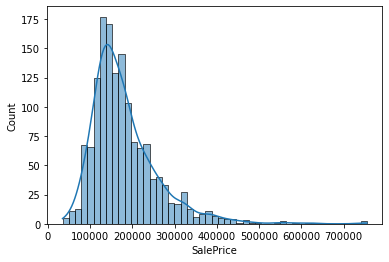

In [3]:
sns.histplot(house_df['SalePrice'], kde=True)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

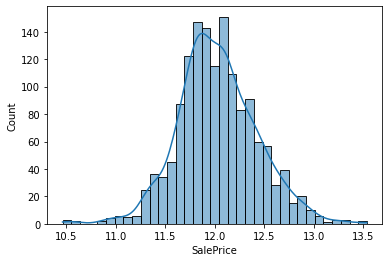

In [4]:
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)

In [5]:
org_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
house_df.fillna(house_df.mean(), inplace=True)

null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print(house_df.dtypes[null_column_count.index])

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [7]:
house_df_ohe = pd.get_dummies(house_df)
print(house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print(house_df_ohe.dtypes[null_column_count.index])

(1460, 271)
Series([], dtype: object)


In [14]:
from sklearn.metrics import mean_squared_error

def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses


In [15]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import train_test_split

y_target = house_df_ohe['SalePrice']
X_feature = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.2, random_state=156)

lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()

def get_train(models, X_train, y_train):
    for model in models:
        model.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_train(models, X_train, y_train)
get_rmses(models)

LinearRegression 0.132
Ridge 0.128
Lasso 0.176


[0.13189576579155027, 0.1275084633405298, 0.1762825055647141]

In [16]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index = X_feature.columns)
    high = coef.sort_values(ascending=False).head(n)
    low = coef.sort_values(ascending=False).tail(n)
    return high, low

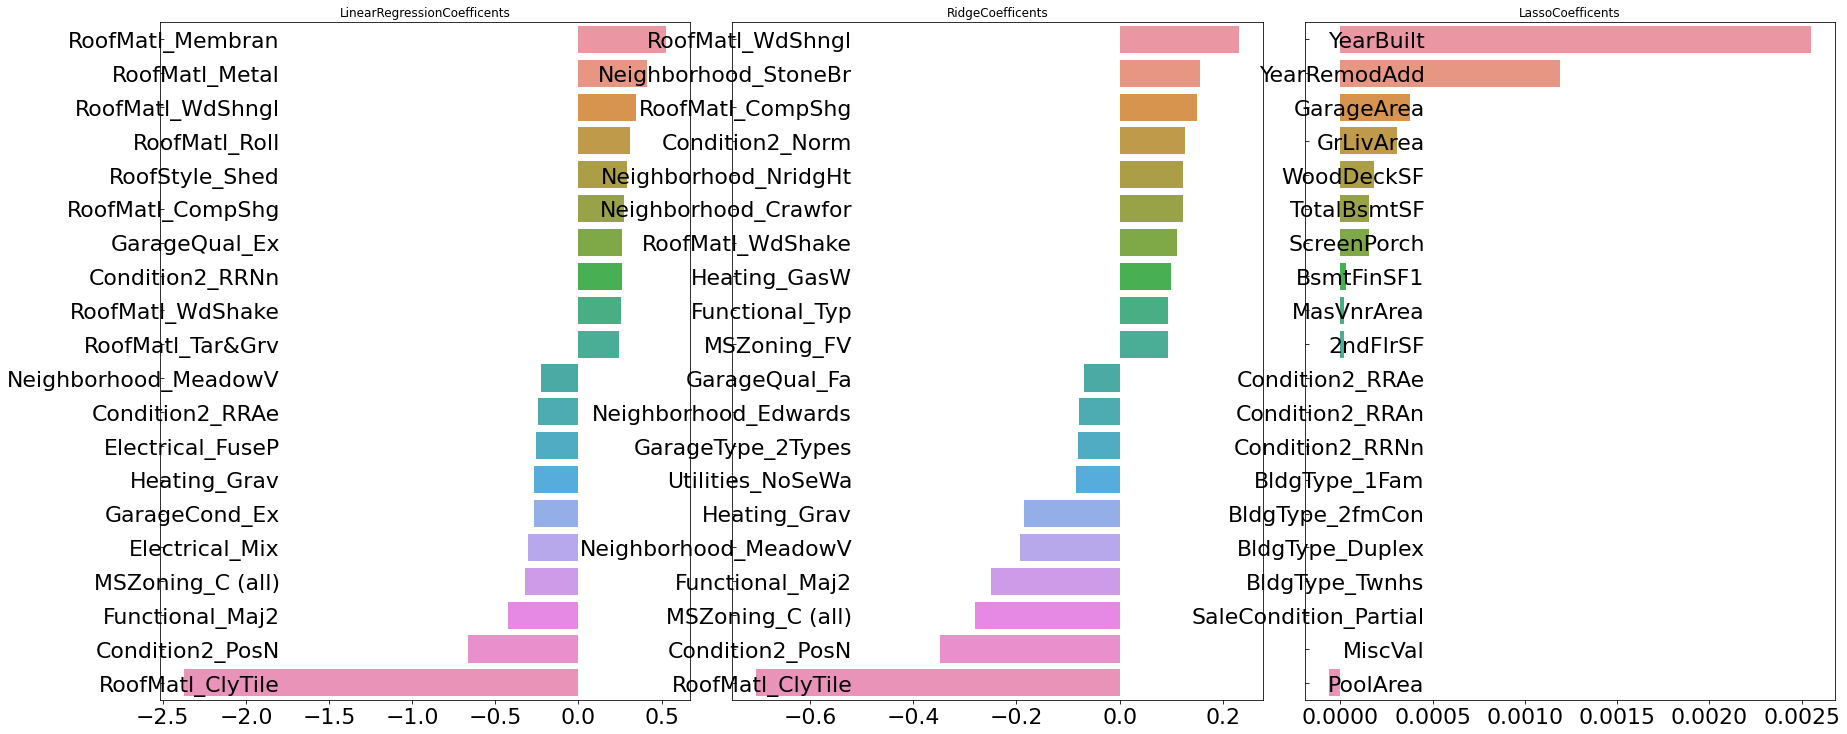

In [18]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()
    for i, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        axs[i].set_title(model.__class__.__name__ + 'Coefficents')
        axs[i].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i])

visualize_coefficient(models)

In [19]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = -cross_val_score(model, X_feature, y_target, scoring='neg_root_mean_squared_error', cv=5)
        rmse = np.mean(rmse_list)
        print(model.__class__.__name__)
        print(np.round(rmse_list,3))
        print('avg: ', np.round(rmse, 3))

get_avg_rmse_cv(models)

LinearRegression
[0.135 0.165 0.168 0.111 0.198]
avg:  0.155
Ridge
[0.117 0.154 0.142 0.117 0.189]
avg:  0.144
Lasso
[0.161 0.204 0.177 0.181 0.265]
avg:  0.198


In [20]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_root_mean_squared_error', cv=5)
    grid_model.fit(X_feature, y_target)
    rmse = -grid_model.best_score_
    print(model.__class__.__name__)
    print(np.round(rmse, 4))
    print(grid_model.best_params_)
    
ridge_params = {'alpha': [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge
0.1393
{'alpha': 12}
Lasso
0.1386
{'alpha': 0.001}


LinearRegression 0.132
Ridge 0.124
Lasso 0.12


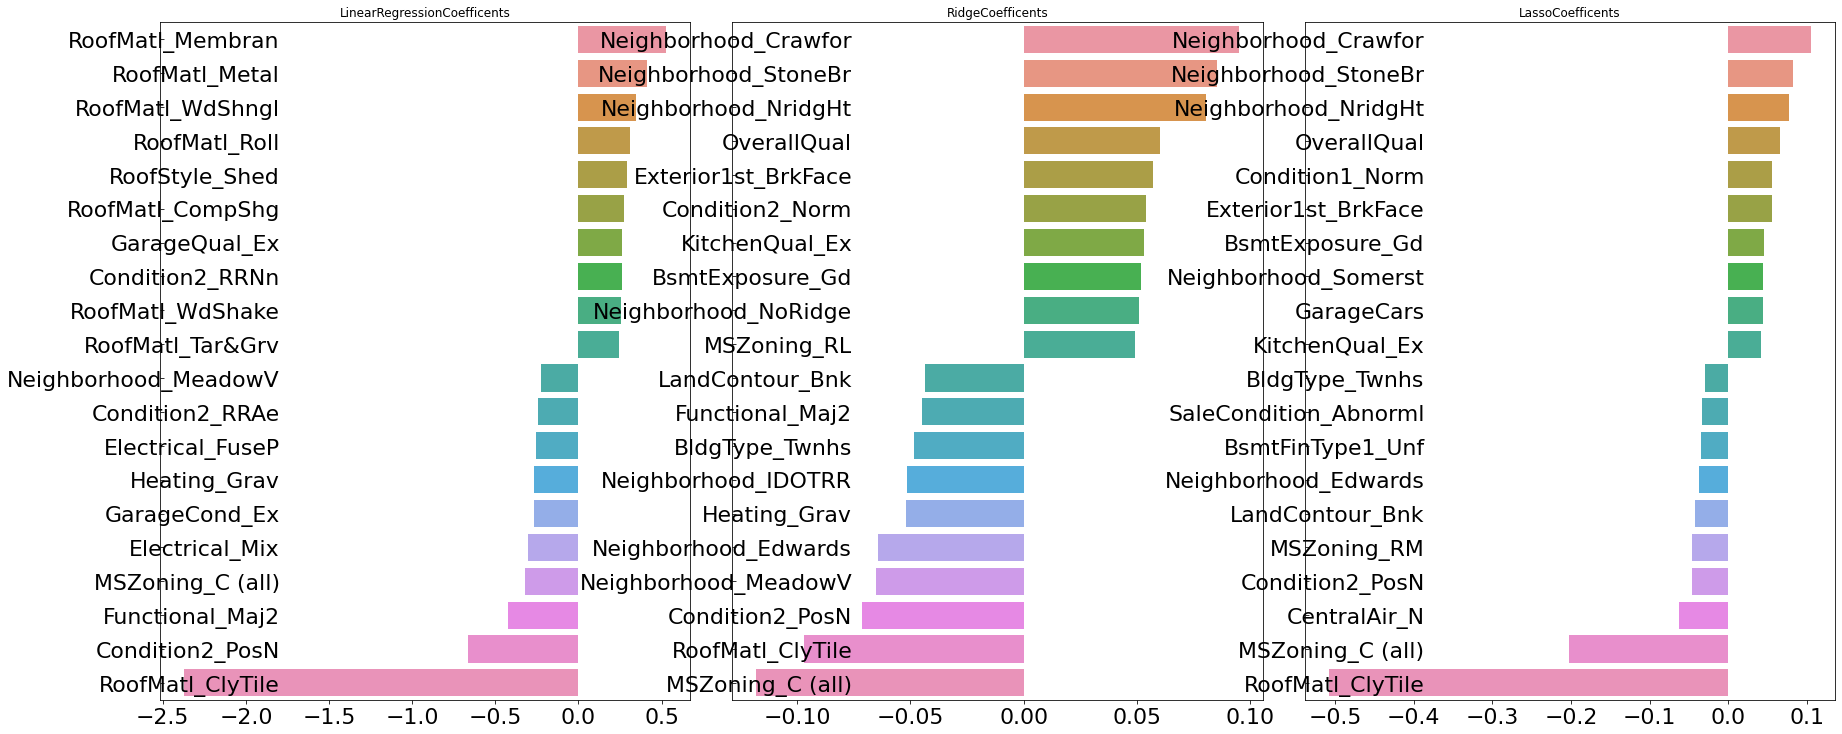

In [21]:
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=12)
lasso_reg = Lasso(alpha=0.001)
models = [lr_reg, ridge_reg, lasso_reg]

get_train(models, X_train, y_train)
get_rmses(models)

visualize_coefficient(models)

In [22]:
# 데이터 왜곡 확인
# 원 핫 인코딩 안된 df 이용

from scipy.stats import skew

feature_index = house_df.dtypes[house_df.dtypes != 'object'].index
skew_feature = house_df[feature_index].apply(lambda x : skew(x))
skew_feature_top = skew_feature[skew_feature > 1]
print(skew_feature_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [23]:
house_df[skew_feature_top.index] = np.log1p(house_df[skew_feature_top.index])

In [24]:
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_feature = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha': [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge
0.1265
{'alpha': 10}
Lasso
0.1241
{'alpha': 0.001}


LinearRegression 0.128
Ridge 0.122
Lasso 0.119


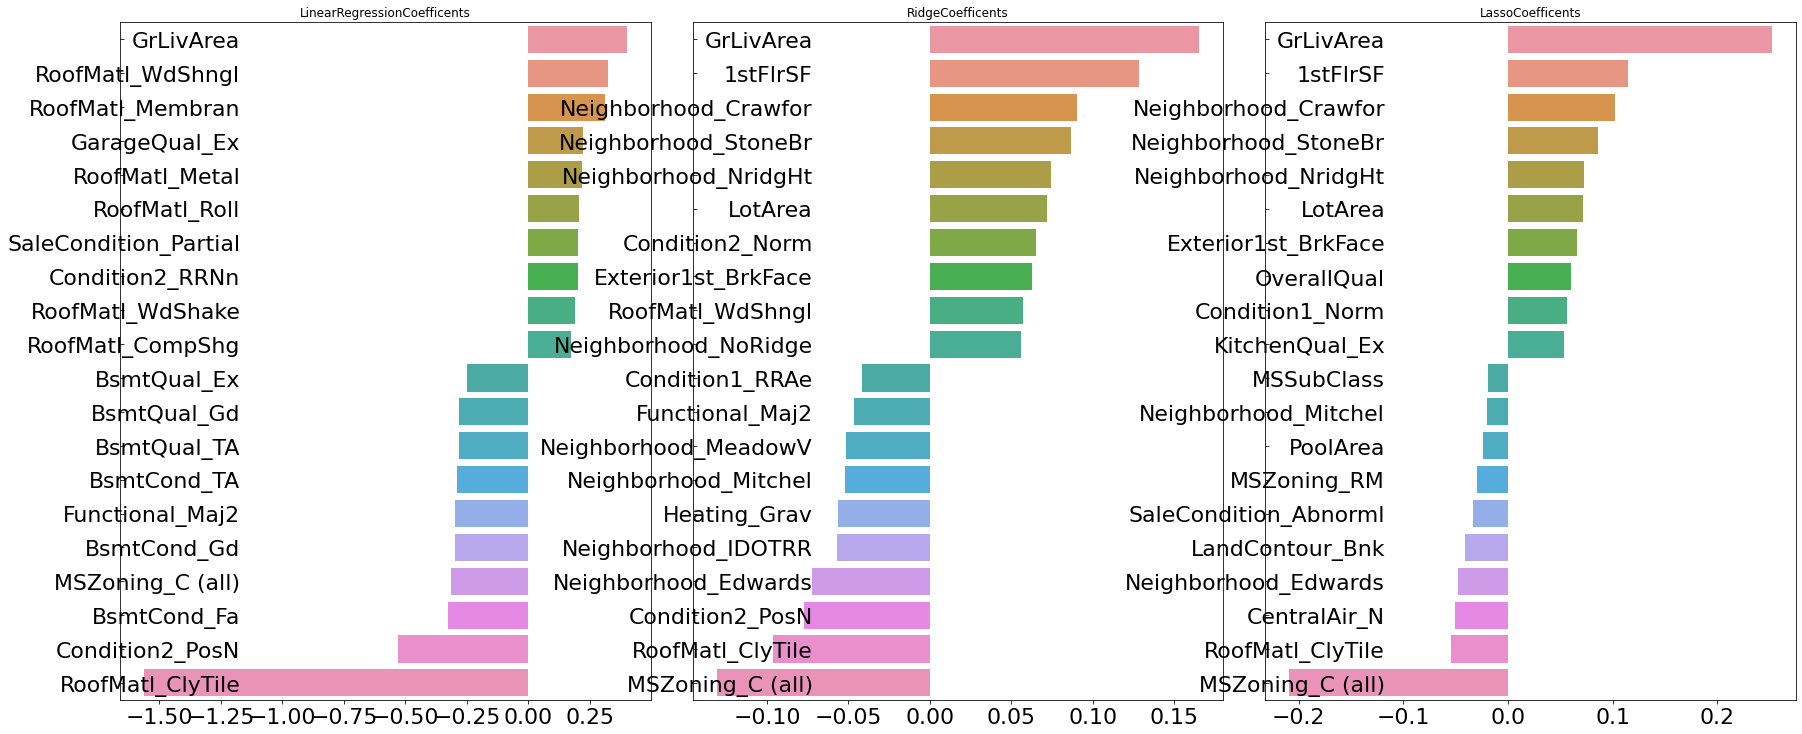

In [25]:
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.001)
models = [lr_reg, ridge_reg, lasso_reg]

get_train(models, X_train, y_train)
get_rmses(models)

visualize_coefficient(models)

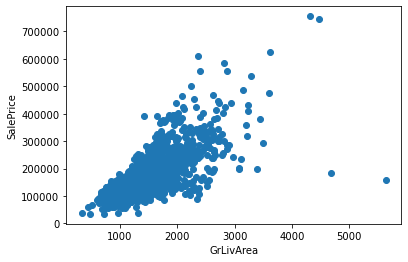

In [28]:
#이상치

plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [29]:
#drop grlivarea > 4000 , saleprice < 500,000
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier = house_df_ohe[cond1 & cond2].index

print(outlier.values)
print(house_df_ohe.shape)
house_df_ohe.drop(outlier, axis=0, inplace=True)
print(house_df_ohe.shape)

[ 523 1298]
(1460, 271)
(1458, 271)


In [30]:
y_target = house_df_ohe['SalePrice']
X_feature = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha': [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge
0.1123
{'alpha': 8}
Lasso
0.112
{'alpha': 0.001}


LinearRegression 0.129
Ridge 0.103
Lasso 0.1


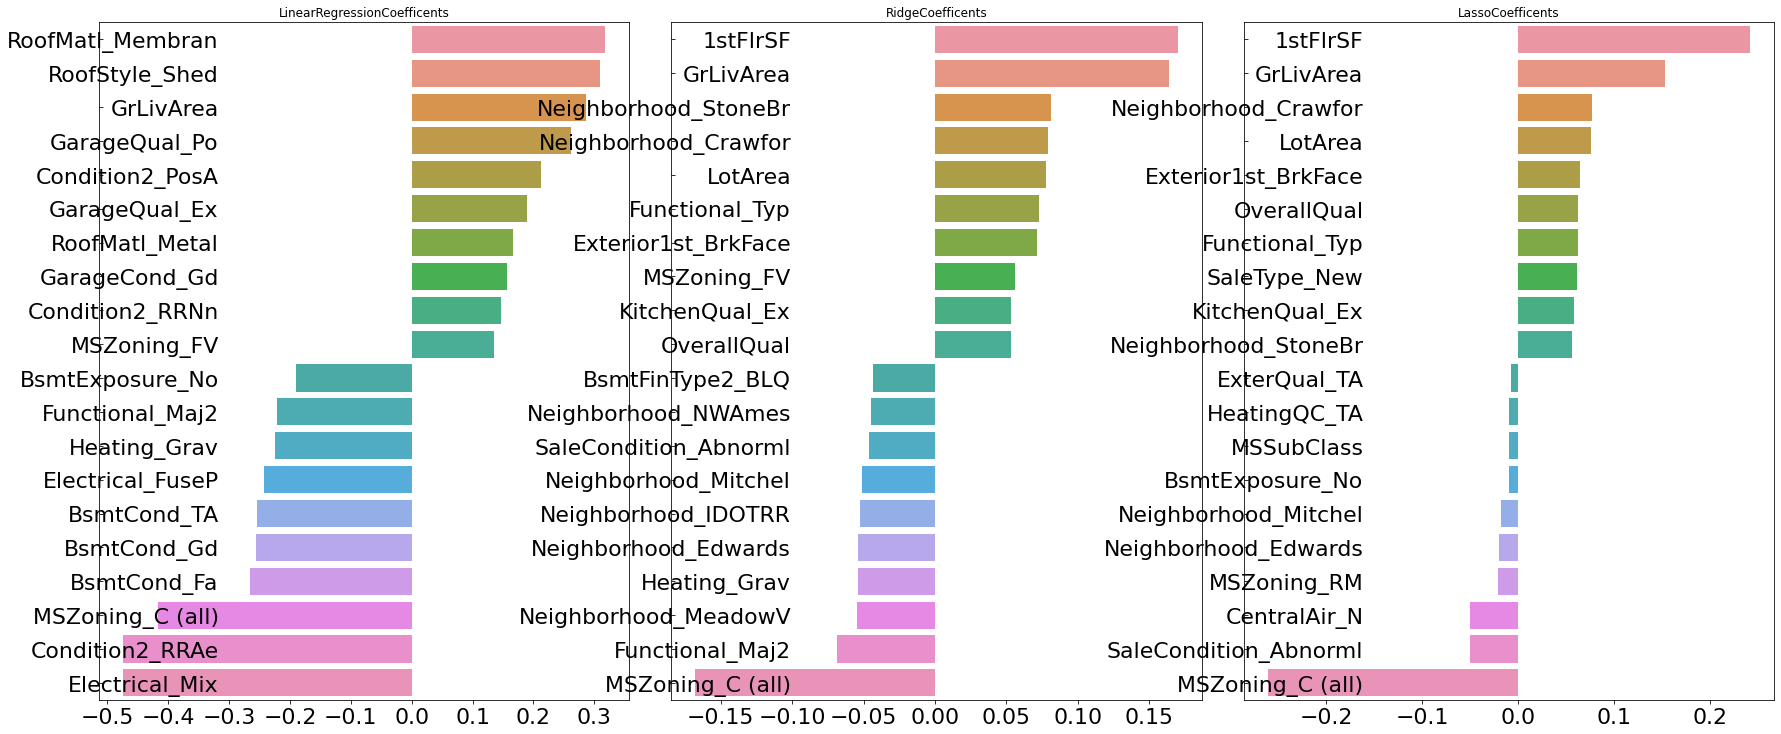

In [31]:
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=8)
lasso_reg = Lasso(alpha=0.001)
models = [lr_reg, ridge_reg, lasso_reg]

get_train(models, X_train, y_train)
get_rmses(models)

visualize_coefficient(models)

In [32]:
#reg tree
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor
0.1195
{'n_estimators': 1000}


In [33]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6,
                        colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor
0.1161
{'n_estimators': 1000}


<AxesSubplot:>

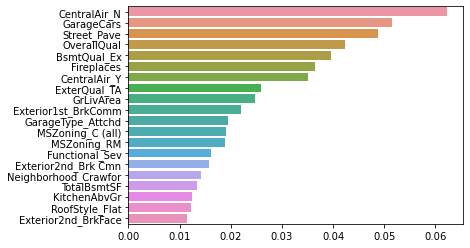

In [41]:
xgb_reg.fit(X_feature, y_target)
coef = pd.Series(xgb_reg.feature_importances_, index=X_feature.columns).sort_values(ascending=False)[:20]
sns.barplot(x=coef, y=coef.index)

<AxesSubplot:>

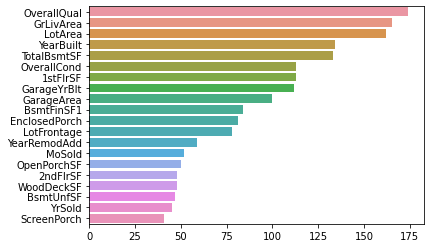

In [42]:
lgbm_reg.fit(X_feature, y_target)
coef = pd.Series(lgbm_reg.feature_importances_, index=X_feature.columns).sort_values(ascending=False)[:20]
sns.barplot(x=coef, y=coef.index)

In [51]:
# 모델 혼합
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test,pred_value)
        rmse = np.sqrt(mse)
        print(key, rmse)

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'혼합' : pred,
        'Ridge': ridge_pred,
        'Lasso': lasso_pred}

get_rmse_pred(preds)

혼합 0.10007930884470521
Ridge 0.10345177546603256
Lasso 0.10024170460890057


In [53]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6,
                        colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'혼합' : pred,
        'xgb': xgb_pred,
        'lgbm': lgbm_pred}

get_rmse_pred(preds)

혼합 0.10277689340617208
xgb 0.10946473825650248
lgbm 0.10382510019327311


In [56]:
#stacking
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False)
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
    
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

In [57]:
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

In [59]:
stack_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
stack_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

meta = Lasso(alpha=0.0005)

meta.fit(stack_X_train, y_train)
final = meta.predict(stack_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print(rmse)

0.0978604423737143
